## top template

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/mkt/04/04_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/mkt/04/04_nb.ipynb)


### 実行環境
OSはmacOSです。LinuxやUnixのコマンドとはオプションが異なりますので注意してください。

In [6]:
!sw_vers

ProductName:		macOS
ProductVersion:		13.5.1
BuildVersion:		22G90


In [7]:
!python -V

Python 3.9.17


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [15]:
import numpy as np
import pandas as pd

import calendar
import random

import matplotlib.pyplot as plt

import faker
from faker import Faker

from watermark import watermark

print(watermark(python=True, watermark=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.17.2

pandas    : 2.0.3
matplotlib: 3.8.1
numpy     : 1.25.2
scipy     : 1.11.2
faker     : 23.2.0

Watermark: 2.4.3



In [13]:
seed = 123
random_state = 123

random.seed(seed)
np.random.seed(seed)

## 顧客分析

顧客分析は、企業が顧客の行動、ニーズ、価値観を理解し、より効果的なマーケティング戦略や製品開発、顧客サービスの改善を図るために行うプロセスです。顧客分析にはさまざまな種類があり、それぞれ異なるデータと分析手法が存在します。

- RFM分析
- STP分析
- CPM分析

それぞれの分析の具体的な実装を行うために、最初に解析対象となるダミーの購買履歴のデータをPythonを利用して作成することにします。

データベースはSQLiteというファイルベースの軽量なデータベースを利用します。また、SQLiteを操作するために、sqlite3というモジュールを利用してSQLを実行します。


### ダミーデータの作成

ダミーデータは、ER図に基づいて作成します。ユーザーテーブル、アイテムテーブル、そして、購買履歴テーブルを作成します。ER図などについてはデータベースの設計に関する書物を参照してください。

ダミーデータを格納するデータベースはSQLiteを利用します。また、PythonからSQLiteへの操作はsqlite3を利用します。

Pythonのsqlite3モジュールは、ファイルベースのSQLiteデータベースを操作するための組み込みライブラリです。sqlite3を利用する事で、データベースの作成、データの挿入、更新、削除、クエリの実行などが簡単にできます。

SQLiteはファイルベースであり、サーバーが不要です。そのため、管理がほとんど不要であり、単一ファイルにデータを格納するため移動やバックアップが容易です。また、ACIDトランザクションと多くのSQL標準に対応しています。

SQLiteは軽量でファイルベースのデータベースであり、大規模トランザクションや高同時アクセスには向いていません。これは、複雑なクエリや大量の読み書きによるパフォーマンス問題と、ネットワーク経由での分散アクセスに対する制限があるためです。SQLiteは中小規模のデータベースやローカル環境に最適です。

本章では、SQLiteに仮想的なデータベースをPythonのsqlite3モジュールを作成します。

![png](04_nb_files_local/dummy.png)

### データベースと各テーブルの作成

最初に、SQLiteのファイルを作成します。``test\_data.db'' という名前でファイルのデータベースを作成します。繰り返しますが、SQLiteはファイルベースのデータベースなので、現在のディレクトリの直下にPythonのosモジュールを利用してテキストファイルと同じように作成します。

このデータベースに、三つのテーブルを作成します。一つ目がユーザーの情報を格納する、Usersテーブルです。二つ目がアイテムの情報を格納する、Itemsテーブルです。三つ目が購買履歴を情報を格納する、PurchaseHistoryテーブルになります。

UsersテーブルはPrimary KeyとしてUserIDを持ち、ユーザーの名前と、誕生日、職業が格納されます。Itemsテーブルには、Primary Keyとして、ItemIDを持ち、アイテムの名前とその値段を格納します。

PurchaseHistoryテーブルは購入したユーザーとアイテムのID、購入した量と日時を格納します。


In [9]:
import os
import sqlite3

user_num = 100
item_num = 3

db_file_name = "test_data.db"

# 古いファイルが存在すれば削除
if os.path.isfile(db_file_name):
    os.remove(db_file_name)

with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    # Users テーブルの作成
    cur.execute(
        """
    CREATE TABLE Users (
        UserID INTEGER PRIMARY KEY AUTOINCREMENT,
        Name TEXT NOT NULL,
        Birthday TEXT,
        Job TEXT
    );
    """
    )

    # Items テーブルの作成
    cur.execute(
        """
    CREATE TABLE Items (
        ItemID INTEGER PRIMARY KEY AUTOINCREMENT,
        Name TEXT,
        Price INTEGER
    );
    """
    )

    # PurchaseHistory テーブルの作成
    cur.execute(
        """
    CREATE TABLE PurchaseHistory (
        PurchaseID INTEGER PRIMARY KEY AUTOINCREMENT,
        UserID INTEGER NOT NULL,
        ItemID INTEGER NOT NULL,
        PurchaseDate TEXT NOT NULL,
        Quantity INTEGER NOT NULL,
        FOREIGN KEY (UserID) REFERENCES Users(UserID),
        FOREIGN KEY (ItemID) REFERENCES Items(ItemID)
    );
    """
    )

    cur.close()
    conn.commit()

テーブルが実際に作成されているか確認します。

In [10]:
with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    # テーブル一覧を取得
    cur.execute(
        """
        SELECT name FROM sqlite_master WHERE type='table';
    """
    )

    table_list = cur.fetchall()

    cur.close()

for i, table in enumerate(table_list):
    print(f"{i + 1}. {table[0]}")

1. Users
2. sqlite_sequence
3. Items
4. PurchaseHistory


SQLite3 の sqlite\_master テーブルはSQLiteデータベースにおけるメタデータを収めたシステムテーブルであり、データベース内のすべてのテーブル、インデックス、ビュー、トリガー等のスキーマ情報を保持しています。

このsqlite\_masterテーブルには、以下のようなカラムが存在します。


- type: このエントリーがどのような種類のオブジェクトを指すのかを示します。例としては、table, index, view, trigger などがあります。
- name: ここにはオブジェクト（テーブル、インデックス、ビュー、トリガー）の名称が記載されています。
- tbl\_name: このカラムは特定のオブジェクトが関連づけられているテーブルの名称を示します。インデックスやトリガーの場合、それらが紐づいているテーブルの名前がここに入ります。
- sql: このカラムには、オブジェクトを生成した際のSQL文が格納されており、テーブル、インデックス、ビュー、トリガーの作成に用いられたCREATE文が含まれています。


sqlite\_masterテーブルにクエリを実行することで、データベースの構造や特定のテーブルやオブジェクトに関する情報を容易に得ることができます。


In [11]:
with sqlite3.connect(db_file_name) as conn:
    sqlite_master_df = pd.read_sql_query("SELECT * FROM sqlite_master", conn)

sqlite_master_df

,type,name,tbl_name,rootpage,sql
0,table,Users,Users,2,CREATE TABLE Users (\n UserID INTEGER P...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,Items,Items,4,CREATE TABLE Items (\n ItemID INTEGER P...
3,table,PurchaseHistory,PurchaseHistory,5,CREATE TABLE PurchaseHistory (\n Purcha...


このテーブルは読み取りのみ可能で、直接編集することはできません。データベースのスキーマに変更が加えられると、sqlite\_masterテーブルも自動的に更新されることになります。


### ユーザーテーブルとアイテムテーブルの作成

ユーザーのダミーデータを作成するために、ここではFakerというライブラリを利用します。

Fakerは、ソフトウェアテスト、機械学習の学習データ生成、データの匿名化など様々な場面で利用される便利なツールです。

名前、住所、電話番号、メールアドレス、パスワードなどの多様なダミーデータを生成でき、これによりソフトウェアのテストを効率化したり、機械学習モデルの学習精度を向上させたり、個人情報の保護を強化することができます。

具体的な利用例としては、Webアプリケーションのテスト、機械学習モデルの学習、データベーステスト、顧客データの匿名化などがあります。

ここでは、Fakerを利用して、ユーザー名と誕生日、仕事をランダムに生成します。また、アイテムについても歯磨き粉や歯ブラシなどを作成します

In [12]:
Faker.seed(seed)
fake = Faker("jp-JP")

with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    for _ in range(user_num):
        name = fake.name()
        birthday = fake.date_of_birth()
        job = fake.job()

        cur.execute(
            f"INSERT INTO Users (Name, Birthday, Job) VALUES (?, ?, ?);",
            (name, birthday, job),
        )

    cur.execute(f"INSERT INTO Items (Name, Price) VALUES (?, ?);", ("歯ブラシ", 100))
    cur.execute(f"INSERT INTO Items (Name, Price) VALUES (?, ?);", ("歯磨き粉", 200))
    cur.execute(f"INSERT INTO Items (Name, Price) VALUES (?, ?);", ("柔軟剤", 500))

    cur.close()
    conn.commit()


### 購買履歴

次に各ユーザーの購入履歴を作成します。

#### ポアソン分布

ポアソン分布は、ある一定時間に平均 $\mu$ 回起こる離散的なイベントの数をモデル化するために使われる確率分布です。

ポアソン分布は、さまざまな現象のモデル化に使用されます。

たとえば、一定期間内に特定の地域で発生する交通事故の数、工場の生産ラインにおいて一定時間に生じる不良品の数、一定時間内にコールセンターにかかってくる電話の数をモデル化する際に利用されます。

$$
    P(X=k)= \frac{e^{-\lambda} \lambda^k}{k !}
$$


期待値平均$E[X]$は、すべての可能な$k$値にわたる確率質量関数の重み付け和です。

$$
\begin{equation}
    \begin{aligned}
        E[X] & =\sum_{k=0}^{\infty} k \cdot P(X=k)=\sum_{k=0}^{\infty} k \cdot \frac{e^{-\lambda} \lambda^k}{k !} =\sum_{k=1}^{\infty} \frac{e^{-\lambda} \lambda^k}{(k-1) !} \\
             & =\lambda e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^{k-1}}{(k-1) !} =\lambda e^{-\lambda} \cdot e^{\lambda} = \lambda
    \end{aligned}
\end{equation}
$$

したがって、ポアソン分布の平均 (期待値) は $\lambda$ に等しくなります。

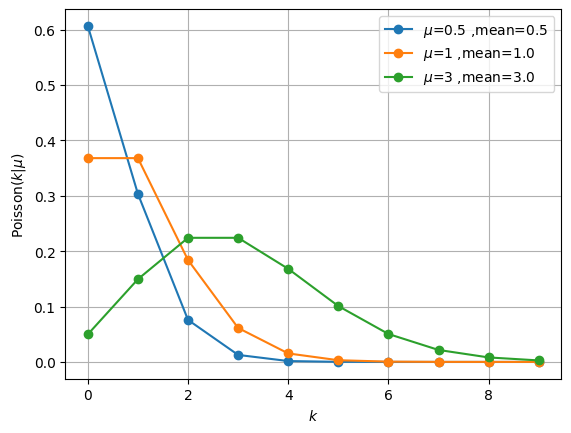

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson

for mu in [0.5, 1, 3]:
    x = np.arange(10)
    mean, var, skew, kurt = poisson.stats(mu, moments="mvsk")
    plt.plot(x, poisson.pmf(x, mu), marker="o", label=f"$\\mu$={mu} ,mean={mean}")

plt.xlabel("$k$")
plt.ylabel("$\\text{Poisson}(k|\mu)$")
plt.grid()
plt.legend()
plt.show()

#### ガンマ分布


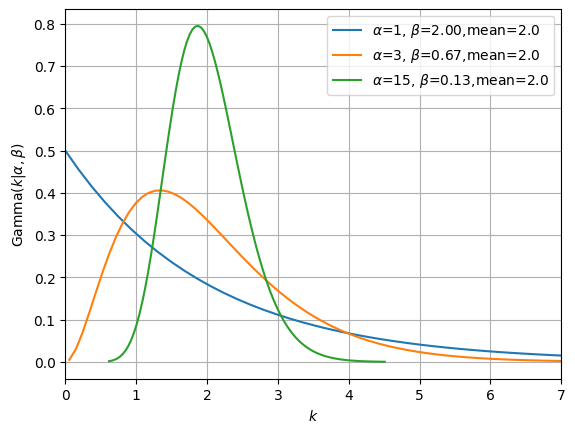

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma

for a, b in zip([1, 3, 15], [2, 2 / 3, 2 / 15]):
    x = np.linspace(gamma.ppf(0.0001, a, scale=b), gamma.ppf(0.9999, a, scale=b), 100)
    mean, var, skew, kurt = gamma.stats(a, scale=b, moments="mvsk")
    plt.plot(x, gamma.pdf(x, a, scale=b), label=f"$\\alpha$={a}, $\\beta$={b:.2f},mean={mean}")

plt.xlim([0, 7])
plt.xlabel("$k$")
plt.ylabel("$\\text{Gamma}(k|\\alpha, \\beta)$")
plt.grid()
plt.legend()
plt.show()

#### 購入履歴の作成

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.stats import poisson

import datetime
from dateutil.relativedelta import relativedelta

purchase_history_size = 60
current_date = datetime.date(2024, 7, 1)

datetime_list = [current_date - relativedelta(months=i + 1) for i in range(purchase_history_size)]

gamma_a_list = [1, 3, 5]
gamma_b_list = [1, 1.5 / 3, 0.5 / 5]

with sqlite3.connect(db_file_name) as conn:
    cur = conn.cursor()

    for a, b, _item_id in zip(gamma_a_list, gamma_b_list, range(1, item_num + 1)):
        mu_list = gamma.rvs(a, scale=b, size=user_num, random_state=random_state)

        for mu, _user_id in zip(mu_list, range(1, user_num + 1)):
            history_list = poisson.rvs(mu, size=purchase_history_size, random_state=random_state)

            for _created_at, _history in zip(datetime_list[::-1], history_list[::-1]):
                if _history > 0:
                    _year = pd.to_datetime(_created_at).year
                    _month = pd.to_datetime(_created_at).month
                    _random_day = random.choice([i + 1 for i in range(calendar.monthrange(_year, _month)[1])])

                    # 年は固定で、日付だけランダムに設定
                    _random_created_at = f"{_year}-{_month}-{_random_day}"

                    cur.execute(
                        f"INSERT INTO PurchaseHistory (UserID, ItemID, Quantity, PurchaseDate) VALUES (?, ?, ?, ?);",
                        (_user_id, _item_id, int(_history), _random_created_at),
                    )

    cur.close()
    conn.commit()

In [16]:
with sqlite3.connect(db_file_name) as conn:
    users_df = pd.read_sql_query("SELECT * FROM Users", conn).set_index("UserID", drop=True)

users_df.head()

,Name,Birthday,Job
UserID,,,
1,渡辺 康弘,1955-05-13,イラストレーター
2,小林 英樹,1946-08-28,YouTuber
3,高橋 太一,1973-03-12,大学教授
4,高橋 涼平,1958-09-24,医師
5,鈴木 花子,1993-01-14,イラストレーター


In [17]:
with sqlite3.connect(db_file_name) as conn:
    items_df = pd.read_sql_query("SELECT * FROM Items", conn).set_index("ItemID", drop=True)

items_df.head()

,Name,Price
ItemID,,
1,歯ブラシ,100
2,歯磨き粉,200
3,柔軟剤,500


In [18]:
with sqlite3.connect(db_file_name) as conn:
    purchase_history_df = pd.read_sql_query("SELECT * FROM PurchaseHistory", conn).set_index("PurchaseID", drop=True)

purchase_history_df.PurchaseDate = pd.to_datetime(purchase_history_df.PurchaseDate)
purchase_history_df["diff_days"] = purchase_history_df.PurchaseDate.apply(
    lambda x: (pd.to_datetime(current_date) - x).days
)
purchase_history_df

,UserID,ItemID,PurchaseDate,Quantity,diff_days
PurchaseID,,,,,
1,1,1,2019-07-02,3,1826
2,1,1,2019-08-09,1,1788
3,1,1,2019-09-03,2,1763
4,1,1,2019-10-25,3,1711
5,1,1,2019-12-14,2,1661
...,...,...,...,...,...
9651,100,3,2023-01-03,1,545
9652,100,3,2023-06-19,1,378
9653,100,3,2023-09-05,1,300


In [19]:
purchase_history_df.groupby(["UserID", "ItemID"])["Quantity"].agg(["mean", "std", "count"])

mean       std  count
UserID ItemID                           
1      1       1.583333  0.767237     48
       2       1.250000  0.440959     28
       3       1.125000  0.353553      8
2      1       1.066667  0.258199     15
       2       2.491228  1.297288     57
...                 ...       ...    ...
99     2       1.439024  0.634381     41
       3       1.062500  0.250000     16
100    1       1.117647  0.332106     17
       2       1.411765  0.556920     34
       3       1.066667  0.258199     15

[300 rows x 3 columns]

## RFM分析

最終購入日（Recency）：顧客が最後にいつ購入したのか（最終購入日からの経過時間が短い顧客を高く評価）
購入頻度（Frequency）：顧客が何回購入したのか（回数の多い顧客を高く評価）
購入金額（Monetary）：顧客が購入した金額合計（金額の高い顧客を高く評価）

1. Recency (最終購入日): 顧客が最後に購入した日からの経過日数。最近購入した顧客は再購入する可能性が高いと考えられます。
2. Frequency (購入頻度): 一定期間内に顧客が行った購入回数。頻繁に購入する顧客は忠実であると見なされ、より価値があるとされます。
3. Monetary (購入金額): 顧客による一定期間内の総購入金額。高い購入金額の顧客はより価値が高いとされます。

これらの指標を用いて、顧客をさまざまなグループに分類し、それぞれに合ったマーケティング戦略を立てます。例えば、最近購入していないが過去に頻繁に購入していた顧客には、再購入を促すような特別なオファーを提供することが考えられます。

RFM分析は、特にリピート購入が重要なビジネスモデルにおいて、顧客の行動をより深く理解し、効果的なカスタマイズされたコミュニケーションを行うのに有効な方法です。この分析を通じて、マーケティングのROI（投資利益率）を高め、顧客満足度を向上させることができます。

### Receny

In [21]:
target_ItemID = 3

recnecy_df = (
    purchase_history_df.sort_values(by=["UserID", "ItemID", "PurchaseDate"])
    .groupby(["UserID", "ItemID"])
    .tail(1)
    .reset_index(drop=True)[["UserID", "ItemID", "diff_days"]]
)

recnecy_df = recnecy_df.rename(columns={"diff_days": "recency"})
recnecy_df

,UserID,ItemID,recency
0,1,1,1
1,1,2,29
2,1,3,210
3,2,1,126
4,2,2,26
...,...,...,...
295,99,2,28
296,99,3,24
297,100,1,21
298,100,2,9


### Frequency

2. Frequency (購入頻度): 一定期間内に顧客が行った購入回数。頻繁に購入する顧客は忠実であると見なされ、より価値があるとされます。

In [22]:
frequency_df = (
    purchase_history_df[purchase_history_df.diff_days < 100]
    .groupby(["UserID", "ItemID"])
    .Quantity.agg(["count"])
    .reset_index()
)

frequency_df = frequency_df.rename(columns={"count": "frequency"})
frequency_df

,UserID,ItemID,frequency
0,1,1,2
1,1,2,2
2,2,2,3
3,2,3,2
4,3,2,2
...,...,...,...
244,98,3,2
245,99,2,3
246,99,3,2
247,100,1,1


### Monetary

購入金額（Monetary）：顧客が購入した金額合計（金額の高い顧客を高く評価）

3. Monetary (購入金額): 顧客による一定期間内の総購入金額。高い購入金額の顧客はより価値が高いとされます。


In [23]:
monetary_df = pd.merge(purchase_history_df, items_df, on="ItemID", how="left")
monetary_df["total"] = monetary_df.apply(lambda x: x.Quantity * x.Price, axis=1)
monetary_df = monetary_df[monetary_df.diff_days < 100].groupby(["UserID", "ItemID"]).total.agg(["sum"]).reset_index()

monetary_df = monetary_df.rename(columns={"sum": "monetary"})
monetary_df

,UserID,ItemID,monetary
0,1,1,300
1,1,2,400
2,2,2,2000
3,2,3,1000
4,3,2,400
...,...,...,...
244,98,3,1000
245,99,2,1000
246,99,3,1000
247,100,1,100


### RFM分析

In [25]:
_temp = pd.merge(recnecy_df, frequency_df, on=["UserID", "ItemID"], how="left").fillna(0)
rfm_df = pd.merge(_temp, monetary_df, on=["UserID", "ItemID"], how="left").fillna(0)
rfm_df

,UserID,ItemID,recency,frequency,monetary
0,1,1,1,2.0,300.0
1,1,2,29,2.0,400.0
2,1,3,210,0.0,0.0
3,2,1,126,0.0,0.0
4,2,2,26,3.0,2000.0
...,...,...,...,...,...
295,99,2,28,3.0,1000.0
296,99,3,24,2.0,1000.0
297,100,1,21,1.0,100.0
298,100,2,9,3.0,1000.0


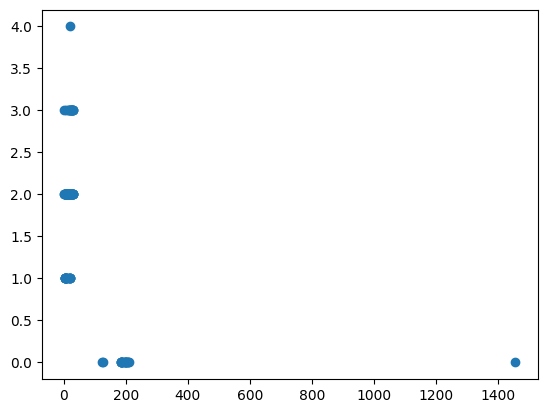

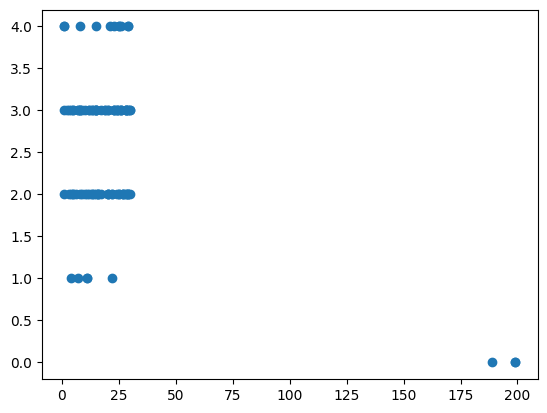

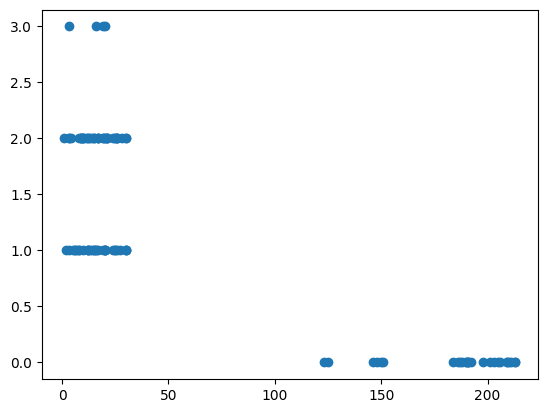

In [26]:
plt.scatter(x=rfm_df[rfm_df.ItemID == 1].recency, y=rfm_df[rfm_df.ItemID == 1].frequency)
plt.show()
plt.scatter(x=rfm_df[rfm_df.ItemID == 2].recency, y=rfm_df[rfm_df.ItemID == 2].frequency)
plt.show()
plt.scatter(x=rfm_df[rfm_df.ItemID == 3].recency, y=rfm_df[rfm_df.ItemID == 3].frequency)
plt.show()

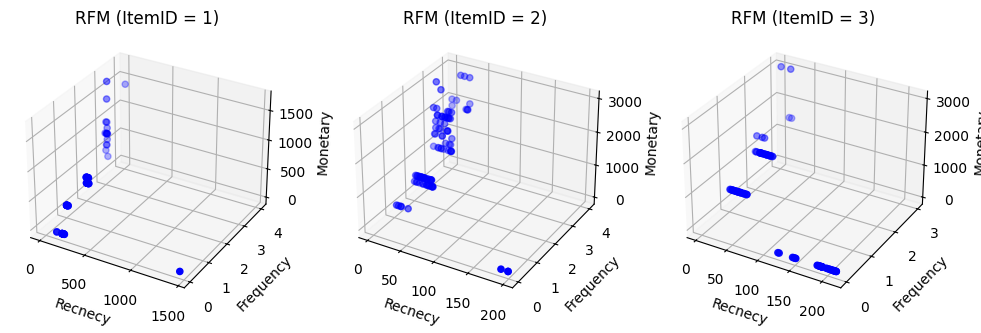

In [27]:
# plt.scatter(x=, y=rfm_df[rfm_df.item_id == 1].frequency)

# import japanize_matplotlib
# import seaborn as sns

# sns.set(font="IPAexGothic")

fig = plt.figure(figsize=(12, 8))

###################################################
ax1 = fig.add_subplot(131, projection="3d")

target_ItemID = 1

_rfm_df = rfm_df[rfm_df.ItemID == target_ItemID]
x = _rfm_df.recency
y = _rfm_df.frequency
z = _rfm_df.monetary

ax1.scatter(x, y, z, s=20, color="blue", label="RFM analysis")

ax1.set_title(f"RFM (ItemID = {target_ItemID})")
ax1.set_xlabel("Recnecy")
ax1.set_ylabel("Frequency")
ax1.set_zlabel("Monetary")

# ax1.legend()

###################################################
ax2 = fig.add_subplot(132, projection="3d")

target_ItemID = 2

_rfm_df = rfm_df[rfm_df.ItemID == target_ItemID]
x = _rfm_df.recency
y = _rfm_df.frequency
z = _rfm_df.monetary

ax2.scatter(x, y, z, s=20, color="blue", label="RFM analysis")

ax2.set_title(f"RFM (ItemID = {target_ItemID})")
ax2.set_xlabel("Recnecy")
ax2.set_ylabel("Frequency")
ax2.set_zlabel("Monetary")

# ax2.legend()


###################################################
ax3 = fig.add_subplot(133, projection="3d")

target_ItemID = 3

_rfm_df = rfm_df[rfm_df.ItemID == target_ItemID]
x = _rfm_df.recency
y = _rfm_df.frequency
z = _rfm_df.monetary

ax3.scatter(x, y, z, s=20, color="blue", label="RFM analysis")

ax3.set_title(f"RFM (ItemID = {target_ItemID})")

ax3.set_xlabel("Recnecy")
ax3.set_ylabel("Frequency")
ax3.set_zlabel("Monetary")

# ax3.legend()


plt.show()

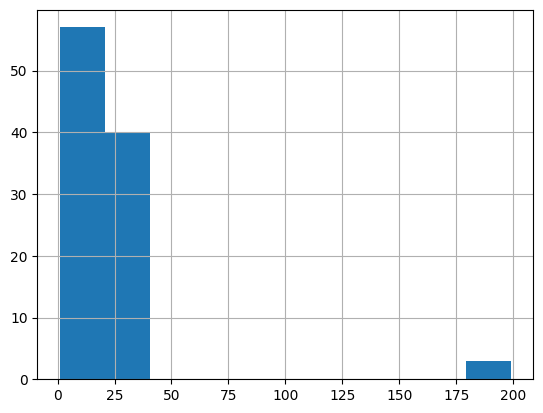

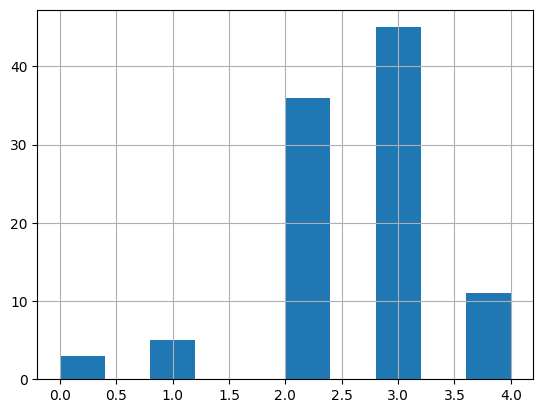

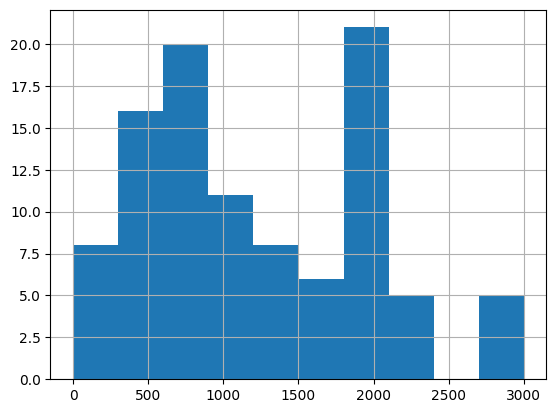

In [28]:
target_ItemID = 2
rfm_df[rfm_df.ItemID == target_ItemID].recency.hist()
plt.show()
rfm_df[rfm_df.ItemID == target_ItemID].frequency.hist()
plt.show()
rfm_df[rfm_df.ItemID == target_ItemID].monetary.hist()
plt.show()

## 結論